In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xgboost as xgb
import functools
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams["figure.facecolor"] = 'FFFFFF'
matplotlib.rcParams['figure.dpi'] = 100

In [2]:
original_data = pd.read_excel('online_retail_II.xlsx', [0, 1])
original_data = pd.concat([original_data[0], original_data[1]], ignore_index=True)

In [3]:
data = original_data.copy()

In [4]:
data['Cancelled'] = (original_data['Invoice'].str[0] == 'C')
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Cancelled'],
      dtype='object')

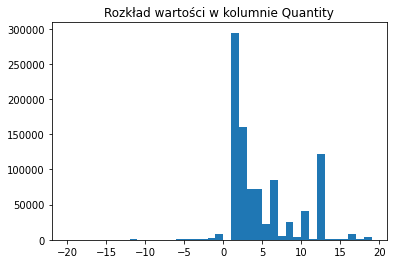

In [5]:
plt.hist(data['Quantity'], bins=list(range(-20, 20, 1)))
plt.title("Rozkład wartości w kolumnie Quantity");

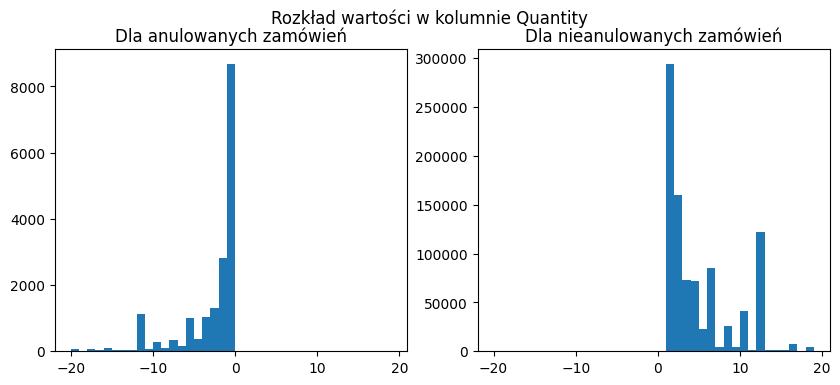

In [7]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Rozkład wartości w kolumnie Quantity")
axes[0].set_title("Dla anulowanych zamówień")
axes[0].hist(data[data['Cancelled']]['Quantity'], bins=list(range(-20, 20, 1)));

axes[1].set_title("Dla nieanulowanych zamówień")
axes[1].hist(data[~data['Cancelled']]['Quantity'], bins=list(range(-20, 20, 1)));

In [8]:
data['Quantity'] = data['Quantity'].abs()

In [9]:
data.isna().any()

Invoice        False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
Price          False
Customer ID     True
Country        False
Cancelled      False
dtype: bool

In [10]:
nan_number = data['Customer ID'].isna().value_counts()[True]
data[data['Customer ID'].isna()]['Customer ID'] = -1
print(f"Replaced {nan_number} NaNs with -1")

Replaced 243007 NaNs with -1


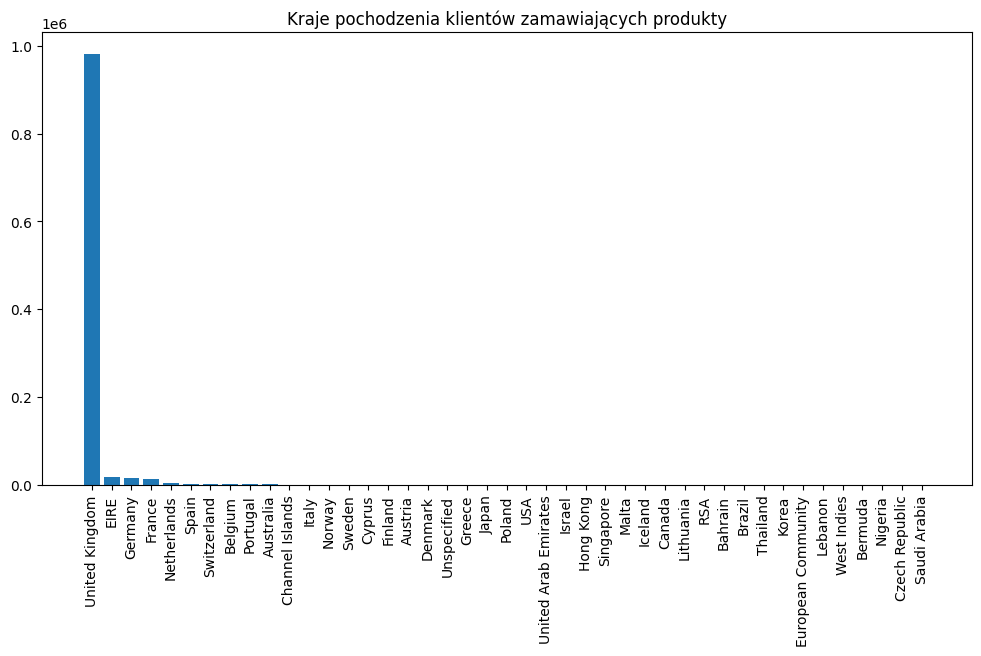

In [11]:
countries = data['Country'].value_counts().to_dict()
plt.figure(figsize=(12, 6))
plt.bar(list(countries.keys()), height=list(countries.values()))
plt.xticks(*plt.xticks(), rotation=90)
plt.title("Kraje pochodzenia klientów zamawiających produkty");

In [12]:
duplicate_amounts = [0 for _ in range(30)]

for group_name, group in data.groupby(by=['StockCode', 'Quantity', 'Price', 'Customer ID']):
    if True in group['Cancelled'].values:
        try:
            not_cancelled = group['Cancelled'].value_counts()[False]
        except KeyError:
            not_cancelled = 0
        while len(duplicate_amounts) <= not_cancelled:
            duplicate_amounts.append(0)
        duplicate_amounts[not_cancelled] += group['Cancelled'].value_counts()[True]

0.381 z anulowanych produktów ma nieanulowany odpowiednik


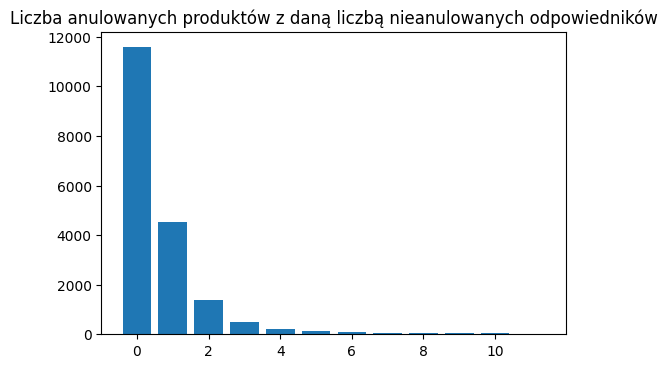

In [13]:
plt.bar(list(range(12)), duplicate_amounts[:12])
plt.title("Liczba anulowanych produktów z daną liczbą nieanulowanych odpowiedników")
print(f"{sum(duplicate_amounts[1:]) / sum(duplicate_amounts):.3f} z anulowanych produktów ma nieanulowany odpowiednik")

In [14]:
grouped_data = data.groupby('Invoice')
print(grouped_data.head())

        Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067355  581587     22631             CIRCUS PARADE LUNCH BOX         12   
1067356  581587     22556       PLASTERS IN TIN CIRCUS PARADE         12   
1067357  581587     22555            PLASTERS IN TIN STRONGMAN        12   
1067358  581587     22728            ALARM CLOCK BAKELIKE PINK         4   
1067359  581587     22727            ALARM CLOCK BAKELIKE RED          4   

                InvoiceDate  Price  Customer ID         Country  Cancelled  
0       20

In [15]:
aggregated = {
    "Invoice": [],
    "EarliestInvoiceDate": [],
    "LatestInvoiceDate": [],
    "PriceSum": [],
    "TotalQuantity": [],
    "DifferentProducts": [],
    
    "Manual": [],
    "Discount": [],
    "ManualSum": [],
    "DiscountSum": [],
    "Cancelled": [],
    
    "isBritish": [],

    "MostCommon1Quantity": [],
    "MostCommon2Quantity": [],
    "MostCommon3Quantity": [],
    "MostCommon1Price": [],
    "MostCommon2Price": [],
    "MostCommon3Price": [],

    "MostExpensive1Price": [],
    "MostExpensive2Price": [],
    "MostExpensive3Price": [],
    "MostExpensive1Quantity": [],
    "MostExpensive2Quantity": [],
    "MostExpensive3Quantity": []


}

for group_name, df_group in grouped_data:
    if all(df_group['StockCode'].isin(['M', 'm', 'S', 'B', 'D'])):
        continue
    assert not any(df_group['StockCode'] == 'S')

    products = ~df_group['StockCode'].isin(['M', 'm', 'D'])

    assert all(df_group['Invoice'] == group_name)
    aggregated['Invoice'].append(group_name)

    aggregated['isBritish'].append(df_group['Country'].iloc[0] == 'United Kingdom')
    
    group_invoice_dates = df_group['InvoiceDate'].sort_values()
    aggregated['EarliestInvoiceDate'].append(group_invoice_dates.iloc[0])
    aggregated['LatestInvoiceDate'].append(group_invoice_dates.iloc[-1])

    aggregated['PriceSum'].append((df_group['Price'] * df_group['Quantity']).sum())
    aggregated['TotalQuantity'].append(df_group['Quantity'].sum())
    aggregated['DifferentProducts'].append(products.value_counts()[True])

    sorted_group = df_group[products].sort_values(by='Quantity',  ascending=True)
    aggregated['MostCommon1Quantity'].append(sorted_group['Quantity'].iloc[0])
    aggregated['MostCommon1Price'].append(sorted_group['Price'].iloc[0])
    if len(sorted_group) > 2:
        aggregated['MostCommon3Quantity'].append(sorted_group['Quantity'].iloc[2])
        aggregated['MostCommon3Price'].append(sorted_group['Price'].iloc[2])

    else:
        aggregated['MostCommon3Quantity'].append(0)
        aggregated['MostCommon3Price'].append(0)

    if len(sorted_group) > 1:
        aggregated['MostCommon2Quantity'].append(sorted_group['Quantity'].iloc[1])
        aggregated['MostCommon2Price'].append(sorted_group['Price'].iloc[1])

    else:
        aggregated['MostCommon2Quantity'].append(0)
        aggregated['MostCommon2Price'].append(0)

    sorted_by_prices = df_group[products].sort_values(by='Price', ascending=True)
    aggregated['MostExpensive1Price'].append(sorted_by_prices['Price'].iloc[0])
    aggregated['MostExpensive1Quantity'].append(sorted_by_prices['Quantity'].iloc[0])
    if len(sorted_by_prices) > 2:
        aggregated['MostExpensive3Price'].append(sorted_by_prices['Price'].iloc[2])
        aggregated['MostExpensive3Quantity'].append(sorted_by_prices['Quantity'].iloc[2])
    else:
        aggregated['MostExpensive3Price'].append(0)
        aggregated['MostExpensive3Quantity'].append(0)
    if len(sorted_by_prices) > 1:
        aggregated['MostExpensive2Price'].append(sorted_by_prices['Price'].iloc[1])
        aggregated['MostExpensive2Quantity'].append(sorted_by_prices['Quantity'].iloc[1])
    else:
        aggregated['MostExpensive2Price'].append(0)
        aggregated['MostExpensive2Quantity'].append(0)

    aggregated['Manual'].append(0)
    aggregated['Discount'].append(0)
    aggregated['ManualSum'].append(0)
    aggregated['DiscountSum'].append(0)

    stock_code_idx = list(df_group.columns).index('StockCode')
    price_idx = list(df_group.columns).index('Price')
    quantity_idx = list(df_group.columns).index('Price')
    
    for row in df_group.values:
        if row[stock_code_idx] in {'M', 'm'}:
            aggregated['Manual'][-1] += 1
            aggregated['ManualSum'][-1] += row[price_idx] * row[quantity_idx]
        elif row[stock_code_idx] == 'D':
            aggregated['Discount'][-1] += 1
            aggregated['DiscountSum'][-1] += row[price_idx] * row[quantity_idx]
        
    aggregated['PriceSum'][-1] -= aggregated['DiscountSum'][-1] * 2

    aggregated['Cancelled'].append(str(group_name)[0] == 'C')

In [16]:
old_agg_data = pd.DataFrame(aggregated)
old_agg_data.columns

Index(['Invoice', 'EarliestInvoiceDate', 'LatestInvoiceDate', 'PriceSum',
       'TotalQuantity', 'DifferentProducts', 'Manual', 'Discount', 'ManualSum',
       'DiscountSum', 'Cancelled', 'isBritish', 'MostCommon1Quantity',
       'MostCommon2Quantity', 'MostCommon3Quantity', 'MostCommon1Price',
       'MostCommon2Price', 'MostCommon3Price', 'MostExpensive1Price',
       'MostExpensive2Price', 'MostExpensive3Price', 'MostExpensive1Quantity',
       'MostExpensive2Quantity', 'MostExpensive3Quantity'],
      dtype='object')

In [17]:
print(len(old_agg_data))
print(len(old_agg_data.drop_duplicates(subset=['PriceSum', 'TotalQuantity'], keep=False)))
# old_agg_data = old_agg_data.drop_duplicates(subset=['PriceSum'], keep=False)
# old_agg_data = old_agg_data.drop_duplicates(subset=['TotalQuantity'], keep=False)
print(len(old_agg_data))
agg_data = old_agg_data

# agg_data = old_agg_data.drop_duplicates(subset=['PriceSum', 'TotalQuantity'], keep=False)

52734
38203
52734


In [18]:
ready_data = agg_data.drop(columns=['Invoice', 'EarliestInvoiceDate', 'LatestInvoiceDate'])
# 'Manual', 'ManualSum', 'Discount', 'DiscountSum', 'EarliestInvoiceDate', 'LatestInvoiceDate', 'PriceSum'
ready_data['InvoiceDate'] = agg_data['EarliestInvoiceDate'].dt.month * 31 + agg_data['EarliestInvoiceDate'].dt.day
ready_data['InvoiceHour'] = agg_data['EarliestInvoiceDate'].dt.hour

In [19]:
train_data, test_data = train_test_split(ready_data, test_size=0.2, random_state=421)
train_X, train_y = train_data.drop(columns=['Cancelled']), train_data['Cancelled']
test_X, test_y = test_data.drop(columns=['Cancelled']), test_data['Cancelled']

In [20]:
model = xgb.XGBClassifier()
model.fit(train_X, train_y)
pred = model.predict(test_X)
print(cohen_kappa_score(test_y, pred))
print(accuracy_score(test_y, pred))

0.7179313143305794
0.9297430548971272


In [21]:
dtrain = xgb.DMatrix(train_X, train_y)

In [24]:
model = xgb.XGBClassifier(n_estimators=cv_results['test-logloss-mean'].argmin())
model.fit(train_X, train_y)
pred = model.predict(test_X)
print(cohen_kappa_score(test_y, pred))
print(accuracy_score(test_y, pred))

0.7217363234973232
0.9305963781170001


In [47]:
params = dict(
    objective='binary:logistic',
    n_jobs=8,
    eta=0.1,
    gamma=0,
    max_depth=6,
    min_child_weight=1,
    subsample=1,
    sampling_method='uniform',
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_lambda=1,
    reg_alpha=2,
    tree_method='exact',
    scale_pos_weight=1,
    refresh_leaf=1,
    process_type='default'
)

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=5,
    stratified=True,
    early_stopping_rounds=50,
    as_pandas=True,
    verbose_eval=False
)
model = xgb.XGBClassifier(**params, n_estimators=cv_results['test-logloss-mean'].argmin())
model.fit(train_X, train_y)
pred = model.predict(test_X)

In [58]:
print(cohen_kappa_score(test_y, pred))
print(accuracy_score(test_y, pred))

0.7266202376750708
0.932018583483455


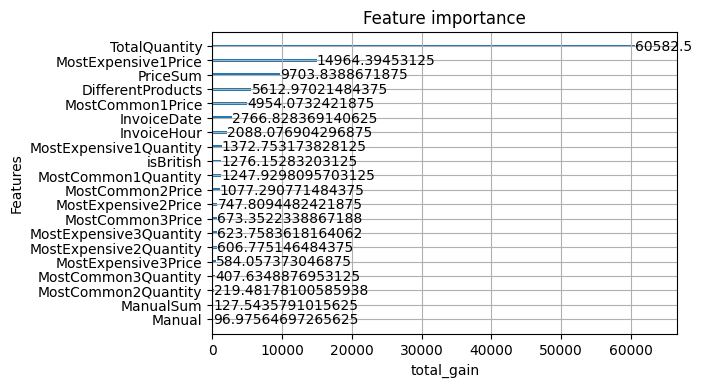

In [63]:
xgb.plot_importance(model, importance_type='total_gain', xlabel='total_gain');